<h1><center>BirdSound Recognition</center></h1>

![](https://m.media-amazon.com/images/I/81g3oOHeYZL._SS500_.jpg)

# Introduction

Our challenge in this competition is to identify which birds are calling in long recordings, given training data generated in meaningfully different contexts. This is the exact problem facing scientists trying to automate the remote monitoring of bird populations.


### Files

1. `train_audio` -  The train data consists of short recordings of individual bird calls

2. `test_audio`  -  The hidden test_audio directory contains approximately 150 recordings in mp3 format, each roughly 10 minutes long. 
The recordings were taken at three separate remote locations in North America. `Sites 1` and `2` were labeled in `5 second increments` and need matching predictions, but due to the time consuming nature of the labeling process the `site 3` files are only labeled at the file level.

3. `test.csv` Only the first three rows are available for download; the full test.csv is in the hidden test set.

4.`train.csv` - A wide range of metadata is provided for the training data. The most directly relevant fields are:

* `ebird_code`: a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.
    
* `recodist`: the user who provided the recording.

* `location`: where the recording was taken. Some bird species may have local call 'dialects', so you may want to seek geographic diversity in your training data.

* `date`: while some bird calls can be made year round, such as an alarm call, some are restricted to a specific season. You may want to seek temporal diversity in your training data.

* `filename`: the name of the associated audio file.

In [ ]:
!pip install nlpaug

# Getting our tools ready

In [ ]:
# tool box

import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import plotly.express as px

import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import sklearn
import librosa.display as librosa_display
import nlpaug
import nlpaug.augmenter.audio as naa

import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import keras
from keras import layers
import random
from keras.models import Sequential
from tqdm import tqdm
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# General Settings

# display all the columns in the dataset
pd.pandas.set_option('display.max_columns', None)

# Setting color palette.
purple_black = [
"#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"
]

# Setting plot styling.
#plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [ ]:
base_path='../input/birdsong-recognition/'
audio_path=base_path+'train_audio/'

# Let's check the metadata (.csv files)

In [ ]:
# training dataset
train = pd.read_csv("/kaggle/input/birdsong-recognition/train.csv")
train.shape

📌 <b>Key Observations:</b>
* Training dataset `train.csv` has 21375 rows and 35 columns

In [ ]:
# lets inspect first few rows of the dataset
train.head()

📌 <b>Key Observations:</b>

* Intersting point to note here is that, each recording has multiple labels associated with it, `species`, `primary label` and `secondary label`. This means that recordings may contain voice of more than one bird, which is quite natural because birds normally sing in groups!

In [ ]:
# check null values
train.isnull().sum().sort_values(ascending = False)[train.isnull().sum()!=0]

In [ ]:
# visualize missing values:
plt.figure(constrained_layout=True, figsize=(12, 8))
percent = (train.isnull().sum().sort_values(ascending=False) / len(train) *
           100)[(train.isnull().sum().sort_values(ascending=False) / len(train) *
                 100) != 0]

missing = pd.DataFrame({"missing%":percent})

sns.barplot(x=missing.index,
            y='missing%',
            data=missing,
            palette=purple_black)
plt.title('Train Data Missing Values')

### Test Dataset

In [ ]:
test = pd.read_csv("/kaggle/input/birdsong-recognition/test.csv")
test.shape

In [ ]:
test

📌 Key Observations:
    Only the first three rows are available for download; the full test.csv is in the hidden test set. 
   
Test dataset has following columns:

`site`: Site ID.

`row_id`: ID code for the row.

`seconds`: the second ending the time window, if any. Site 3 time windows cover the entire audio file and have null entries for seconds.

`audio_id`: ID code for the audio file.

# Exploratory Data Analysis

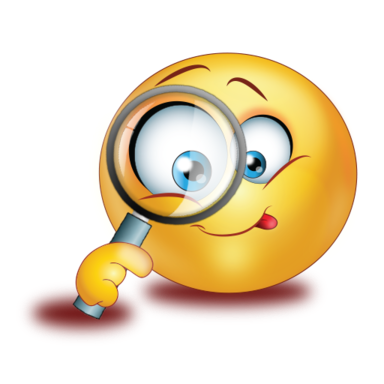

### 1. Let's check the class distribution (no. of unique birds in the dataset)

In [ ]:
# no of unique classes(birds) in the dataset
print("dataset has",train.species.nunique(),"unique bird's species")

In [ ]:
# count wise distribution of bird's species
count = train.species.value_counts().sort_values(ascending = False)
count

In [ ]:
# lets visualize class distribution in the dataset
fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)
fig.show()

📌 Key Observations:
* We have 264 unique bird species
* Blackpoll Warbler, American Crow,Veery & Lesser Goldfinch are few of the most frequently present in the dataset 

### 2. Let's check recording location - Country

* country: Species recorded location

In [ ]:
# country
print("training dataset has data from",train.country.nunique(),"unique countries")

In [ ]:
# lets visualize top 10 countries
plt.figure(constrained_layout=True, figsize=(16, 8))
sns.countplot(train.country,
              alpha=0.9,              
              palette=purple_black,
              order = train.country.value_counts().sort_values(ascending=False).iloc[:10].index,)
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Country wise Distribution")
plt.show()

📌 Key Observations:
* Majority of the recordings are done in USA, followed by CANADA and MEXICO

### 3.Let's explore latitude and longitude, we will plot our birds on the world map

* latitude: latitude co-ordinate of the earth
* longitude: longitude co-ordinate of the earth

In [ ]:
# world shape file
world_map = gpd.read_file("../input/worldshapefile/world_shapefile.shp")

# Coordinate reference system
crs = {"init" : "epsg:4326"}

In [ ]:
# let's filter out "not specified" values
df = train[train["latitude"] != "Not specified"]

# convert latitude and longitute to float variables
df["latitude"] = df["latitude"].astype(float)
df["longitude"] = df["longitude"].astype(float)

In [ ]:
# create geometric list
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

# create geography dataframe
geo = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Create ID for species
species = geo["species"].value_counts().reset_index()
species.insert(0, 'ID', range(0, 0 + len(species)))

species.columns = ["ID", "species", "count"]

# merge the dataframes
geo = pd.merge(geo, species, how="left", on="species")

In [ ]:
# visualize bird's on the world map!
fig, ax = plt.subplots(figsize = (20, 9))
world_map.plot(ax=ax, alpha=0.4, color="blue")

palette = iter(sns.hls_palette(len(species)))

for i in range(264):
    geo[geo["ID"] == i].plot(ax=ax, markersize=30, color=next(palette), marker="o");
    
plt.title("These colorful small circles are our birds :-)")

### 4. lets explore "date" feature

In [ ]:
# check the date format
train.date.head()

In [ ]:
# lets pull year from the given date

train['year'] = train['date'].apply(lambda x: x.split('-')[0])

# lets visualize year wise distribution

fig = plt.figure(constrained_layout=True, figsize=(20,8))

sns.countplot(train.year,             
              alpha=0.9,              
              palette=purple_black,           
              order = train.year.value_counts().sort_values(ascending=False).iloc[:15].index   
             )
plt.xlabel("Year")
plt.ylabel("Count")
plt.title('Year-Wise Distribution')

plt.show()

📌 Key Observations:
* No. of recording started increasing from 2012, max recordings in 2014

In [ ]:
# lets pull month from the date
train['month'] = train['date'].apply(lambda x: x.split('-')[1])

# lets visualize month wise distribution

fig = plt.figure(constrained_layout=True, figsize=(20,8))

sns.countplot(train.month,             
              alpha=0.9,              
              palette=purple_black,           
              order = train.month.value_counts().sort_values(ascending=False).index   
             )
plt.xlabel("Month")
plt.ylabel("Count")
plt.title('Month-Wise Distribution')
plt.show()

📌 Key Observations:
* Max recording are in the month of May(End of Spring) & June(Start of Summer)

### 5. Let's check ebird code & sci_name        

ebird_code - a code for the bird species. You can review detailed information about the bird codes by appending the code to https://ebird.org/species/, such as https://ebird.org/species/amecro for the American Crow.**

* sci_name: Scientific Name of the Bird         

In [ ]:
print("There are",train.ebird_code.nunique(),"ebird codes in the dataset")
print("training dataset has",train.sci_name.nunique(),"unique sci_names")

In [ ]:
# lets visualize ebird code & sci_name

fig = plt.figure(constrained_layout=True, figsize=(20,8))

grid = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
sns.countplot(train.ebird_code,             
              alpha=0.9,
              ax=ax1,
              palette=purple_black,           
              order = train.ebird_code.value_counts().sort_values(ascending = False).iloc[:15].index   
             )
plt.xlabel("Ebird Code")
plt.ylabel("Count")
plt.title('Ebird Code Distribution')
plt.xticks(rotation=30)

ax2 = fig.add_subplot(grid[0, 2:4])
sns.countplot(train.sci_name,             
              alpha=0.9,
              ax=ax2,
              palette=purple_black,           
              order = train.sci_name.value_counts().sort_values(ascending = False).iloc[:15].index   
             )
plt.xlabel("Scientific Name")
plt.ylabel("Count")
plt.title('Scientific Name Distribution')
plt.xticks(rotation=30)
plt.show()

📌 Key Observations:

There are as many unique ebird codes as the no. of species,also the distribution is same as species, which means each ebird code represnts one particular species

There are 264 unique scientific names,equal to the no. of species, seems to have 1:1 mapping with species

### 6. Lets inspect filename,title,description,xc_id & url

* title : Ebird_Code with Species Name
* filename: name of the associated audio file present in the train_audio directory.
* description: Description about the recording provided by the recordist
* xc_id: xeno-canto bird Id
* url: xeno-canto Bird Link

In [ ]:
# lets check the no. of unique values for the field filename
print("training dataset has",train.filename.nunique(),"unique filenames")
print("training dataset has",train.title.nunique(),"unique titles")
print("training dataset has",train.description.nunique(),"unique descriptions")
print("training dataset has",train.xc_id.nunique(),"unique xc_id")
print("training dataset has",train.url.nunique(),"unique urls")

📌 Key Observations:

There are 21375 unique filenames & titles in the dataset, which is equal to the no. of rows in the dataset, which means each row has a unique filename and a unique title corresponding to a recording

There are 12694 unique descriptions and 6199 missing values, this field seems to be like a remark field

There are 21375 unique xc_id & urls in the dataset, which is equal to the no. of rows in the dataset, which means each row has a unique xc_id & unique url corresponding to a recording

In [ ]:
# lets check top 3 descriptions and see how it looks like
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
sns.countplot(train.description,
              alpha=0.9,              
              palette=purple_black,
              order= train.description.value_counts().sort_values(ascending = False).iloc[:3].index)

plt.xlabel("Description")
plt.ylabel("Count")
plt.title('Description Distribution')

fig.show()

### 7. Next set of fields that we will examine are playback_used, channel & rating

* rating: rates the audio quality from 0-5
* playback_used: Was playback used to lure the bird ?
* channels: stereo or mono

In [ ]:
# lets visualize top Playback used, channel & Ratings fields

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# playback used
ax1 = fig.add_subplot(grid[0, :2])

sns.countplot(train.playback_used,
              alpha=0.9,
              ax=ax1,
              order= train.playback_used.value_counts().sort_values(ascending = False).index,
              palette=purple_black)

plt.xlabel("Playback_Used")
plt.ylabel("Count")
ax1.set_title('PlayBack Used Distribution')

# channels.
ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.
sns.countplot(train.channels,
              alpha=0.9,
              ax=ax2,
              order= train.channels.value_counts().sort_values(ascending = False).index,
              palette=purple_black)

plt.xlabel("Channels")
plt.ylabel("Count")
ax2.set_title('Channels Distribution')

# Ratings
ax3 = fig.add_subplot(grid[1, :])

sns.countplot(train.rating,
              alpha=0.9,
              ax = ax3,
              palette=purple_black,              
              order= train.rating.value_counts().sort_values(ascending = False).index)

plt.xlabel("Ratings")
plt.ylabel("Count")
ax3.set_title('Ratings Distribution')

plt.show()

📌 Key Observations:

* For most of the recordings present in the dataset, playback was not used
* Channels seems to have almost equal distribution
* Most of the audio have good ratings, kind of an indication that people usually loves bird's voice

### 8. Next set of fields that we will examine are pitch, no. of notes & speed

* pitch: Was the Pitch of the Bird Call increasing / decreasing or constant
* number_of_notes: No: of Syllables
* speed: whether speed is constant (level), decreasing (decelerating), increasing (accelerating), or both (in either order

In [ ]:
# lets visualize pitch, speed & no. of notes

fig = plt.figure(constrained_layout=True, figsize=(20, 9))
# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# pitch
ax1 = fig.add_subplot(grid[0, :2])

sns.countplot(train.pitch,
              alpha=0.9,
              ax=ax1,
              palette=purple_black,
              order= train.pitch.value_counts().sort_values(ascending = False).index)
plt.xlabel("Pitch")
plt.ylabel("Count")
ax1.set_title('Pitch Distribution')



# speed
ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.
sns.countplot(train.speed,
              alpha=0.9,
              ax=ax2,
              palette=purple_black,
              order= train.speed.value_counts().sort_values(ascending = False).index)

plt.xlabel("Speed")
plt.ylabel("Count")
ax2.set_title('Speed Distribution')

# number_of_notes
ax3 = fig.add_subplot(grid[1, :])

sns.countplot(train.number_of_notes,
              alpha=0.9,
              ax=ax3,
              palette=purple_black,
              order= train.number_of_notes.value_counts().sort_values(ascending = False).index)
plt.xlabel("Number Of Notes Distribution")
plt.ylabel("Count")
ax3.set_title('Number Of Notes')

plt.show()

📌 Key Observations:

* pitch/speed - most of the values for these field are not specified
* number of notes is not specified for majority of the records

### 9. Lets take a look at duration

* duration: Total Recording in Seconds

In [ ]:
plt.figure(constrained_layout=True, figsize=(12, 8))
sns.distplot(train.duration,
            color='coral')

plt.xlabel("Duration")
plt.ylabel("Count")
plt.title('Duration Distribution')


📌 Key Observations:
* duration of most of the audio files are between 0 to 300 seconds

### 10. Lets inspect primary and secondary labels

* primary_label: Meta-Data for Labeling Birds in Xeno Catalog
* secondary_labels : Background Birds Identified

In [ ]:
# lets check the no. of unique values for the field primary & secondary labels
print("training dataset has",train.primary_label.nunique(),"unique primary labels")

print("training dataset has",train.secondary_labels.nunique(),"unique secondary labels")

In [ ]:
# lets visualize primary labels
plt.figure(constrained_layout=True, figsize=(12, 8))

count = train.primary_label.value_counts().sort_values(ascending = False)[:50]

fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)

fig.show()

In [ ]:
# lets visualize seconary labels
plt.figure(constrained_layout=True, figsize=(12, 8))

count = train.secondary_labels.value_counts().sort_values(ascending = False)[:20]

fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)

fig.show()

📌 Key Observations:
* We have 264 unique primary labels, which is equal to the no. of unique species
* Primary labels are equally distributed in the dataset
* We have 5385 unique secondary labels, even though for majority of the audio clips, this field is left blank "[]" 

### 11. Lets inspect bird seen, sampling rate and type

* bird_seen: Was the Bird Seen during the recording
* sampling_rate: Digital Samples recorded per second, most of the samples are 44.1kHz / 48kHz
* Type of Bird Sound Recorded. Wing Noise / Song / Call / Flight Call

In [ ]:
# lets visualize bird_seen, sampling rate and type fields

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# playback used
ax1 = fig.add_subplot(grid[0, :2])

sns.countplot(train.bird_seen,
              alpha=0.9,
              ax=ax1,
              palette=purple_black,              
              order = train.bird_seen.value_counts().sort_values(ascending = False).index)
plt.xlabel("Bird Seen Distribution")
plt.ylabel("Count")
ax1.set_title('Bird Seen')


# sampling_rate.
ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.
sns.countplot(train.sampling_rate,
              alpha=0.9,
              ax=ax2,
              palette=purple_black,
              order = train.sampling_rate.value_counts().sort_values(ascending = False).index)

plt.xlabel("Sampling Rate Distribution")
plt.ylabel("Count")
ax2.set_title('Sampling Rate')

# type              
ax3 = fig.add_subplot(grid[1, :])

sns.countplot(train.type              ,
              alpha=0.9,
              ax = ax3,
              palette=purple_black,           
              order = train.type.value_counts().sort_values(ascending = False).iloc[:10].index)
            
plt.xlabel("Type Distribution")
plt.ylabel("Count")
plt.xticks(rotation = 30)
ax3.set_title('Type')

plt.show()

📌 Key Observations:

* In most of the cases birds were seen while recording
* Sampling rate is mostly 44100 and 48000 Hz
* In most if the cases birds were found either actually singing or calling when they were recorded

### 12. Lets inspect volume,length and elevation

* elevation: Height from Sea Level
* length: This is the length of the Bird Call, not the length of the recording.
* volume:

In [ ]:
# lets visualize elevation,volume,length

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)


# sampling_rate.
ax1 = fig.add_subplot(grid[0, :2])

# Plot the countplot.
sns.countplot(train.length,
              alpha=0.9,
              ax=ax1,
              palette=purple_black,
              order = train.length.value_counts().sort_values(ascending = False).index)

plt.xlabel("Length Distribution")
plt.ylabel("Count")
ax1.set_title('Length')

# volume              
ax2 = fig.add_subplot(grid[0, 2:])

sns.countplot(train.volume,
              alpha=0.9,
              ax = ax2,
              palette=purple_black,           
              order = train.volume.value_counts().sort_values(ascending = False).index,   
             )
plt.xlabel("Volume Distribution")
plt.ylabel("Count")
ax2.set_title('Volume')

# elevation              
ax3 = fig.add_subplot(grid[1, :])
sns.countplot(train.elevation,
              alpha=0.9,
              ax = ax3,
              palette=purple_black,           
              order = train.elevation.value_counts().sort_values(ascending = False).iloc[:15].index,   
             )
plt.xlabel("Elevation Distribution")
plt.ylabel("Count")
ax3.set_title('Elevation')

plt.show()

📌 Key Observations:
* Length & Volumne is not specified for majority of the recordings

* Elevation is 0-10 for majortity of the records

### 13. Lets inspect file type, license, bitrate_of_mp3

* file_type - Audio File type and mostly every file is a mp3
* license - License of the recording
* birate_of_mp3 - Number of Bits used for encoding per second

In [ ]:
# lets visualize file type, license, bitrate_of_mp3

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# playback used
ax1 = fig.add_subplot(grid[0, :2])

sns.countplot(train.file_type,
              alpha=0.9,
              ax=ax1,
              palette=purple_black,
              order = train.file_type.value_counts().sort_values(ascending = False).index)
plt.xlabel("File Type")
plt.ylabel("Count")
ax1.set_title('File Type Distribution')


# sampling_rate.
ax2 = fig.add_subplot(grid[0, 2:])

# using short forms for liecense values
train['license'] = train['license'].replace(["Creative Commons Attribution-NonCommercial-ShareAlike 4.0"],["CCA-NCSA4.0"])
train['license'] = train['license'].replace(["Creative Commons Attribution-NonCommercial-ShareAlike 3.0"],["CCA-NCSA3.0"])
train['license'] = train['license'].replace(["Creative Commons Attribution-ShareAlike 3.0"],["CCA-SA3.0"])
train['license'] = train['license'].replace(["Creative Commons Attribution-ShareAlike 4.0"],["CCA-SA4.0"])
                                          

# Plot the countplot.
sns.countplot(train.license,
              alpha=0.9,
              ax=ax2,
              palette=purple_black,
              order = train.license.value_counts().sort_values(ascending = False).index)

plt.xlabel("License")
plt.ylabel("Count")
ax2.set_title('License Distribution')

# type              
ax3 = fig.add_subplot(grid[1, :])

sns.countplot(train.bitrate_of_mp3,              
              alpha=0.9,
              ax = ax3,
              palette=purple_black,           
              order = train.bitrate_of_mp3.value_counts().sort_values(ascending = False).iloc[:10].index)
plt.xlabel("Bitrate Of Mp3")
plt.ylabel("Count")
ax3.set_title('Bitrate Of Mp3  Distribution')

plt.show()

📌 Key Observations:

* Majority of the recordings are in mp3 format
* First 2 category forms the majority for license type
* 128000 bps is the most frequently used bitrate for recoding

### 14. Lets inspect background, author & recordist

recordist: Name of the recordist
background: Background Birds Identified
author: Person who recorded the audio

In [ ]:
# lets visualize background
plt.figure(constrained_layout=True, figsize=(12, 8))

count = train.background.value_counts().sort_values(ascending = False)[:20]

fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)

fig.show()

In [ ]:
# lets visualize author
plt.figure(constrained_layout=True, figsize=(12, 8))

count = train.author.value_counts().sort_values(ascending = False)[:20]

fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)

fig.show()

In [ ]:
# lets visualize recordist
plt.figure(constrained_layout=True, figsize=(12, 8))

count = train.recordist.value_counts().sort_values(ascending = False)[:20]

fig = px.pie(count,
             values=count.values,
             names=count.index,
             color_discrete_sequence=purple_black,
             hole=.4)
fig.update_traces(textinfo='percent', pull=0.05)

fig.show()

# Audio Files Analysis

`Audio Signal`

* The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.
  It is a complex signal composed of multiple ‘single-frequency sound waves’ which travel together as a disturbance(pressure-change) in the medium. 

  When sound is recorded we only capture the resultant amplitudes of those multiple waves. 



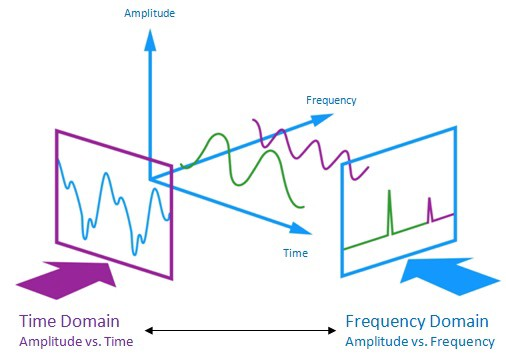

`Sampling`

* Sound is a continuous wave. We can digitise sound by breaking the continuous wave into discrete signals. This process is called sampling. Sampling converts a sound wave into a sequence of samples or a discrete-time signal.

`Sampling Rate (sr)`
* The sampling rate is the number of samples per second. Hz or Hertz is the unit of the sampling rate. 20 kHz is the audible range for human beings.

`Amplitudes`
* From the definition of sound waves — This amplitude is actually the amplitude of air particles which are oscillating because of the pressure change in the atmosphere due to sound.

* These amplitudes are not very informative, as they only talk about the loudness of audio recording. 
 
`Fourier Transform`

* To better understand the audio signal, it is necessary to transform it into the frequency-domain. The frequency-domain representation of a signal tells us what different frequencies are present in the signal. 

* Fourier Transform is a mathematical concept that can convert a continuous signal from time-domain to frequency-domain. 

### LIBROSA

We will use `LibROSA` package to analyse audio files , it provides the building blocks necessary to create audio information retrieval systems.

We will also use `IPython.display` package to listen to audio files in the notebook.

In [ ]:
print('Minimum samples per category = ', min(train.ebird_code.value_counts()))
print('Maximum samples per category = ', max(train.ebird_code.value_counts()))

📌 Key Observations:
* The number of audio samples per category is non-nform. The minimum number of audio samples in a category is 9 while the maximum is 100

### 1. Let's listen to some music!

In [ ]:
perfal = '/kaggle/input/birdsong-recognition/train_audio/perfal/XC463087.mp3'   # Hi-hat
ipd.Audio(perfal)

In [ ]:
lotduc = '/kaggle/input/birdsong-recognition/train_audio/lotduc/XC121426.mp3'   # Hi-hat
ipd.Audio(lotduc)


In [ ]:
rewbla = '/kaggle/input/birdsong-recognition/train_audio/rewbla/XC135672.mp3'   # Hi-hat
ipd.Audio(rewbla)

In [ ]:
warvir = '/kaggle/input/birdsong-recognition/train_audio/warvir/XC192521.mp3'   # Hi-hat
ipd.Audio(warvir)

In [ ]:
lecthr = '/kaggle/input/birdsong-recognition/train_audio/lecthr/XC141435.mp3'   # Hi-hat
ipd.Audio(lecthr)

librosa.display is used to display the audio files in different formats such as `wave plot`, `spectrogram`, or `colormap` 

### 2. Waveplots,Spectogram, Mel-Spectorgram


* `Waveplots` let us know the loudness of the audio at a given time. Waveplot is the time-domain representation of a given signal. 
    This shows us the loudness (amplitude) of sound wave changing with time. Here amplitude = 0 represents silence. 


* `Spectogram` is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given music signals (shows different frequencies playing at a particular time along with it’s amplitude)

* `Mel-Spectogtram` it represents an acoustic time-frequency representation of a sound, it is a normal Spectrogram, but with a Mel Scale on the y axis

In [ ]:
def audioinfo(filename, species):   
    # The load functions loads the audio file and converts it into an array of values which represent the amplitude if a sample at a 
    # given point of time.

    data,sample_rate1 = librosa.load(filename, res_type='kaiser_best')

    print("data:",data,"\n")
    print("Sample Rate (KHz):",sample_rate1)

    # lenth of the audio
    print('Audio Length:', np.shape(data)[0]/sample_rate1)
    
    # ----------------------------------------------------------WAVE PLOT-----------------------------------------------------------
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    
    # Amplitude and frequency are important parameters of the sound and are unique for each audio. 

    # librosa.display.waveplot is used to plot waveform of amplitude vs time where the first axis is an amplitude and second axis is time
   
    librosa.display.waveplot(data,sr=sample_rate1,color = 'darkblue')
    plt.xlabel("Time (seconds) -->")
    plt.ylabel("Amplitude")
    plt.title("Waveplot for - " + species)
    
    # --------------------------------------------------------SPECTOGRAM------------------------------------------------------------
    plt.subplot(3,1,2)
     # .stft converts data into short term Fourier transform. STFT converts signal such that we can know the amplitude of given 
     # frequency at a given time. Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio
     # signal. 
    X = librosa.stft(data)

    Xdb = librosa.amplitude_to_db(abs(X))

    #.specshow is used to display spectogram.
    librosa.display.specshow(Xdb, sr=sample_rate1, x_axis='time', y_axis='hz',cmap = 'winter') 

    plt.colorbar()
    plt.xlabel("Time (seconds) -->")
    plt.ylabel("Amplitude")
    plt.title("Spectogram for - " + species)
    
    # ----------------------------------------------------MEL SPECTOGRAM----------------------------------------------------------
    plt.subplot(3,1,3)
    librosa.feature.melspectrogram(y=data, sr=sample_rate1)

    D = np.abs(librosa.stft(data))**2
    S = librosa.feature.melspectrogram(S=D)
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate1)

    librosa.display.specshow(librosa.power_to_db(S,ref=np.max),x_axis='time',cmap = 'rainbow')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel spectrogram for species - " + species)
    plt.xlabel("Time (seconds) -->")
    plt.ylabel("Amplitude")   
     
    plt.show()

In [ ]:
audioinfo('/kaggle/input/birdsong-recognition/train_audio/perfal/XC463087.mp3',"perfal")

In [ ]:
audioinfo('/kaggle/input/birdsong-recognition/train_audio/lotduc/XC121426.mp3',"lotduc")

In [ ]:
audioinfo("/kaggle/input/birdsong-recognition/train_audio/rewbla/XC135672.mp3","rewbla")

In [ ]:
audioinfo( '/kaggle/input/birdsong-recognition/train_audio/warvir/XC192521.mp3',"warvir")

In [ ]:
audioinfo("/kaggle/input/birdsong-recognition/train_audio/lecthr/XC141435.mp3","lecthr")

### 3.Zero Crossing Rate

* The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.

In [ ]:
def zero_cross(filename):
    data,sample_rate1 = librosa.load(filename)
    # Zooming in
    n0 = 9000
    n1 = 9100
    plt.figure(figsize=(20, 5))
    plt.plot(data[n0:n1],color = "gold")
    plt.grid()
    
    zero_crossings = librosa.zero_crossings(data, pad=False)
    print("Zero Crossing Shape:",zero_crossings.shape)
    
    print("Total Zero Crossings:",sum(zero_crossings))

In [ ]:
zero_cross(perfal)

In [ ]:
zero_cross(lotduc)

In [ ]:
zero_cross(rewbla)

In [ ]:
zero_cross(warvir)

In [ ]:
zero_cross(lecthr)

### 4. Spectral Centroid

* The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located.

In [ ]:
def spectral_centroid(filename):
    data,sample_rate1 = librosa.load(filename)
    
    spectral_centroids = librosa.feature.spectral_centroid(data, sr=sample_rate1)[0]
    spectral_centroids.shape

    # Computing the time variable for visualization
    plt.figure(figsize=(20,5))
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    # Normalising the spectral centroid for visualisation
    def normalize(data, axis=0):
        return sklearn.preprocessing.minmax_scale(data, axis=axis)

    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveplot(data, sr=sample_rate1, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')

In [ ]:
spectral_centroid(perfal)

In [ ]:
spectral_centroid(lotduc)

In [ ]:
spectral_centroid(rewbla)

In [ ]:
spectral_centroid(warvir)

In [ ]:
spectral_centroid(lecthr)

### 5. Spectral Rolloff

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

In [ ]:
def rolloff(filename):
    data,sample_rate1 = librosa.load(filename)
    
    spectral_centroids = librosa.feature.spectral_centroid(data, sr=sample_rate1)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    def normalize(data, axis=0):
        return sklearn.preprocessing.minmax_scale(data, axis=axis)

    plt.figure(figsize=(20,5))
    spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sample_rate1)[0]
    librosa.display.waveplot(data, sr=sample_rate1, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='g')
    plt.grid()

In [ ]:
rolloff(perfal)

In [ ]:
rolloff(lotduc)

In [ ]:
rolloff(rewbla)

In [ ]:
rolloff(warvir)

In [ ]:
rolloff(lecthr)

### 6. MFCC
* Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"

In [ ]:
# MFCC
def mfcc(filename):
    data,sample_rate1 = librosa.load(filename)
    plt.figure(figsize=(20,5))
    mfccs = librosa.feature.mfcc(data, sr=sample_rate1)
    print(mfccs.shape)

    librosa.display.specshow(mfccs, sr=sample_rate1, x_axis='time')

In [ ]:
mfcc(perfal)

In [ ]:
mfcc(lotduc)

In [ ]:
mfcc(rewbla)

In [ ]:
mfcc(warvir)

In [ ]:
mfcc(lecthr)

### 7. Chrome Frequencies


In [ ]:
def chrom_freq(filename):
    data,sample_rate1 = librosa.load(filename)
    
    hop_length = 512
    chromagram = librosa.feature.chroma_cqt(data, sr=sample_rate1, hop_length=hop_length)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length)

In [ ]:
chrom_freq(perfal)

In [ ]:
chrom_freq(lotduc)

In [ ]:
chrom_freq(rewbla)

In [ ]:
chrom_freq(warvir)

In [ ]:
chrom_freq(lecthr)

### 8. Fundamental Frequency Estimation using probabilistic YIN algo**

Used to calculate the fundamental frequency curve from given audio input

In [ ]:
def fundamental_frequency(filename):
    y, sr = librosa.load(filename)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    times = librosa.times_like(f0)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    ax.set(title='pYIN fundamental frequency estimation')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax.legend(loc='upper right')

In [ ]:
fundamental_frequency(perfal)

In [ ]:
fundamental_frequency(warvir)

In [ ]:
fundamental_frequency(lotduc)

In [ ]:
fundamental_frequency(lecthr)

In [ ]:
fundamental_frequency(rewbla)

### 9. Rhythm Fetaure
Tempogram - local autocorrelation of the onset strength envelope

In [ ]:
def compute_tempogram(filename):
    # computing local onset autocorrelation
    y,sr = librosa.load(filename)
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
    
    # Computing global onset autocorrelation
    ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    ac_global = librosa.util.normalize(ac_global)
    
    # Estimating global tempo
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]
    
    # plotting
    
    fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
    times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
    ax[0].plot(times, oenv, label='Onset strength')
    ax[0].label_outer()
    ax[0].legend(frameon=True)
    librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='tempo', cmap='magma',
                             ax=ax[1])
    ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
                label='Estimated tempo={:g}'.format(tempo))
    ax[1].legend(loc='upper right')
    ax[1].set(title='Tempogram')
    x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                    num=tempogram.shape[0])
    ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
    ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
    ax[2].set(xlabel='Lag (seconds)')
    ax[2].legend(frameon=True)
    freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
    ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
                 label='Mean local autocorrelation', basex=2)
    ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
                 label='Global autocorrelation', basex=2)
    ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8,
                label='Estimated tempo={:g}'.format(tempo))
    ax[3].legend(frameon=True)
    ax[3].set(xlabel='BPM')
    ax[3].grid(True)

In [ ]:
compute_tempogram(lecthr)

In [ ]:
compute_tempogram(warvir)

In [ ]:
compute_tempogram(perfal)

In [ ]:
compute_tempogram(lotduc)

### 10. Harmonic-percussive source separaton from audio input

hpss: It will decompose an audio time series into harmonic and percussive components.

In [ ]:
def decompose_audio(filename):
    y,sr = librosa.load(filename)
    D = librosa.stft(y)
    #y_harmonic, y_percussive = librosa.effects.hpss(D, margin=(1.0,5.0)) # we will get more isolated percussive component by increasing margin 
    D_harmonic, D_percussive = librosa.decompose.hpss(D)
    # Pre-compute a global reference power from the input spectrum
    rp = np.max(np.abs(D))

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
    plt.colorbar()
    plt.title('Full spectrogram')

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
    plt.colorbar()
    plt.title('Harmonic spectrogram')

    plt.subplot(3, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
    plt.colorbar()
    plt.title('Percussive spectrogram')
    plt.tight_layout()

In [ ]:
decompose_audio(perfal)

In [ ]:
decompose_audio(lotduc)

In [ ]:
decompose_audio(warvir)

In [ ]:
decompose_audio(lecthr)

# Audio Augmentation

## Change pitch and speed

In [ ]:
def pitch_speed(filename):
    data, sr = librosa.load(filename)
    pitch_speed = data.copy()
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    print("resample length_change = ",length_change)
    tmp = np.interp(np.arange(0,len(pitch_speed),speed_fac),np.arange(0,len(pitch_speed)),pitch_speed)
    minlen = min(pitch_speed.shape[0], tmp.shape[0])
    pitch_speed *= 0
    pitch_speed[0:minlen] = tmp[0:minlen]
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(pitch_speed, sr=sr, color='r', alpha=0.25)
    plt.title('augmented pitch and speed')
    return ipd.Audio(data, rate=sr)

In [ ]:
pitch_speed(perfal)

In [ ]:
pitch_speed(lotduc)

In [ ]:
pitch_speed(rewbla)

In [ ]:
pitch_speed(warvir)

In [ ]:
pitch_speed(lecthr)

## Change pitch only

In [ ]:
def pitch(filename):
    data, sr = librosa.load(filename)
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    print("pitch_change = ",pitch_change)
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                          sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(y_pitch, sr=sr, color='r', alpha=0.25)
    plt.title('augmented pitch only')
    plt.tight_layout()
    plt.show()
    return ipd.Audio(data, rate=sr)

In [ ]:
pitch(perfal)

In [ ]:
pitch(lotduc)

In [ ]:
pitch(rewbla)

In [ ]:
pitch(warvir)

In [ ]:
pitch(lecthr)

## Change speed only

In [ ]:
def speed(filename):
    data, sr = librosa.load(filename)
    aug = naa.SpeedAug()
    augmented_data = aug.augment(data)

    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)
    plt.title('augmented speed only')
    plt.tight_layout()
    plt.show()
    return ipd.Audio(augmented_data, rate=sr)

In [ ]:
speed(perfal)

In [ ]:
speed(lotduc)

In [ ]:
speed(rewbla)

In [ ]:
speed(warvir)

In [ ]:
speed(lecthr)

## value augmentation

In [ ]:
def augmentation(filename):
    data, sr = librosa.load(filename)
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5,high=3)
    print("dyn_change = ",dyn_change)
    y_aug = y_aug * dyn_change
    print(y_aug[:50])
    print(data[:50])
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(y_aug, sr=sr, color='r', alpha=0.25)
    plt.title('amplify value')
    return ipd.Audio(y_aug, rate=sr)

In [ ]:
augmentation(perfal)

In [ ]:
augmentation(lotduc)

In [ ]:
augmentation(rewbla)

In [ ]:
augmentation(warvir)

In [ ]:
augmentation(lecthr)

## Adding Noise

In [ ]:
def add_noise(filename):
    data, sr = librosa.load(filename)
    y_noise = data.copy()
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
    y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(y_noise, sr=sr, color='r', alpha=0.25)
    return ipd.Audio(y_noise, rate=sr)

In [ ]:
add_noise(perfal)

In [ ]:
add_noise(lotduc)

In [ ]:
add_noise(rewbla)

In [ ]:
add_noise(warvir)

In [ ]:
add_noise(lecthr)

## random shifting

In [ ]:
def random_shift(filename):
    data, sr = librosa.load(filename)
    y_shift = data.copy()
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    print("timeshift_fac = ",timeshift_fac)
    start = int(y_shift.shape[0] * timeshift_fac)
    print(start)
    if (start > 0):
        y_shift = np.pad(y_shift,(start,0),mode='constant')[0:y_shift.shape[0]]
    else:
        y_shift = np.pad(y_shift,(0,-start),mode='constant')[0:y_shift.shape[0]]
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(y_shift, sr=sr, color='r', alpha=0.25)
    return ipd.Audio(y_shift, rate=sr)

In [ ]:
random_shift(perfal)

In [ ]:
random_shift(lotduc)

In [ ]:
random_shift(rewbla)

In [ ]:
random_shift(warvir)

In [ ]:
random_shift(lecthr)

## Applying hpss

In [ ]:
def hpss(filename):
    data, sr = librosa.load(filename)
    y_hpss = librosa.effects.hpss(data.astype('float64'))
    print(y_hpss[1][:10])
    print(data[:10])
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(y_hpss[1], sr=sr, color='r', alpha=0.25)
    plt.title('apply hpss')
    return ipd.Audio(y_hpss[1], rate=sr)

In [ ]:
hpss(perfal)

In [ ]:
hpss(lotduc)

In [ ]:
hpss(rewbla)

In [ ]:
hpss(warvir)

In [ ]:
hpss(lecthr)

## Streching

In [ ]:
def streching(filename):
    data, sr = librosa.load(filename)
    input_length = len(data)
    streching = data.copy()
    streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(streching, sr=sr, color='r', alpha=0.25)
    
    plt.title('stretching')
    return ipd.Audio(streching, rate=sr)

In [ ]:
streching(perfal)

In [ ]:
streching(lotduc)

In [ ]:
 streching(rewbla)

In [ ]:
 streching(warvir)

In [ ]:
streching(lecthr)

## cropping

In [ ]:
def crop(filename):
    data, sr = librosa.load(filename)
    aug = naa.CropAug(sampling_rate=sr)
    augmented_data = aug.augment(data)

    librosa_display.waveplot(augmented_data, sr=sr, alpha=0.5)
    librosa_display.waveplot(data, sr=sr, color='r', alpha=0.25)

    plt.tight_layout()
    plt.show()

    return ipd.Audio(augmented_data, rate=sr)

In [ ]:
crop(perfal) 

In [ ]:
crop(lotduc)

In [ ]:
crop(rewbla)

In [ ]:
crop(warvir)

In [ ]:
crop(lecthr)

## Loudness Augmentation

In [ ]:
def loudnessaug(filename):
    data, sr = librosa.load(filename)
    aug = naa.LoudnessAug(loudness_factor=(2, 5))
    augmented_data = aug.augment(data)

    librosa_display.waveplot(augmented_data, sr=sr, alpha=0.25)
    librosa_display.waveplot(data, sr=sr, color='r', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return ipd.Audio(augmented_data,rate=sr)

In [ ]:
loudnessaug(perfal) 

In [ ]:
loudnessaug(lotduc)

In [ ]:
loudnessaug(rewbla)

In [ ]:
loudnessaug(warvir)

In [ ]:
loudnessaug(lecthr)

## Mask Augmentation

In [ ]:
def mask(filename):
    data, sr = librosa.load(filename)
    aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
    augmented_data = aug.augment(data)

    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

    plt.tight_layout()
    plt.show()
    
    return ipd.Audio(augmented_data, rate=sr)

In [ ]:
mask(perfal)

In [ ]:
mask(lotduc)

In [ ]:
mask(rewbla)

In [ ]:
mask(warvir)

In [ ]:
mask(lecthr)

## Shift Augmentation

In [ ]:
def shift(filename):
    data, sr = librosa.load(filename)
    aug = naa.ShiftAug(sampling_rate=sr)
    augmented_data = aug.augment(data)

    librosa_display.waveplot(data, sr=sr, alpha=0.5)
    librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.25)

    plt.tight_layout()
    plt.show()
    
    return ipd.Audio(augmented_data, rate=sr)

In [ ]:
shift(perfal)

In [ ]:
shift(lotduc)

In [ ]:
shift(rewbla)

In [ ]:
shift(warvir)

In [ ]:
shift(lecthr)

# **Model Pre-Processing**

1. Now we will prepare adict with unique birds and Key into the dict

In [ ]:
train_set= train.copy()
birds_key=train["ebird_code"].unique()
birds_key

In [ ]:
random.shuffle(birds_key)
train_set = train_set.query("ebird_code in @birds_key")

idBirdDict = {}
ebirdDict = {}
ebirdDict["nocall"] = 0
idBirdDict[0] = "nocall"
for idx, unique_ebird_code in enumerate(train_set.ebird_code.unique()):
    ebirdDict[unique_ebird_code] = str(idx+1)
    idBirdDict[idx+1] = str(unique_ebird_code)

In [ ]:
ebirdDict

In [ ]:
idBirdDict

In [ ]:
#Let create a Sample Set as Whote data set will run for long hours
sample_set=pd.DataFrame(columns=['ebird_code','audio_File_path',"song_sample","bird"])

In [ ]:
#Using Francois's code to extract the data/ run model

def get_sample(filename, bird, sample_set):
    min_max_Scaler=MinMaxScaler()
    wave_data, wave_rate = librosa.load(filename)
    data_point_per_second = 10
    
    #Take 10 data points every second
    prepared_sample = wave_data[0::int(wave_rate/data_point_per_second)]
    #We normalize each sample before extracting 5s samples from it
    normalized_sample = min_max_Scaler.fit_transform(prepared_sample.reshape(-1, 1))
    normalized_sample = normalized_sample.flatten()
    
    #only take 5s samples and add them to the dataframe
    song_sample = []
    sample_length = 5*data_point_per_second
    for idx in range(0,len(normalized_sample),sample_length): 
        song_sample = normalized_sample[idx:idx+sample_length]
        if len(song_sample)>=sample_length:
            sample_set = sample_set.append({"song_sample":np.asarray(song_sample).astype(np.float32),
                                            "bird":ebirdDict[bird],
                                           "audio_File_path":filename,
                                           "ebird_code":bird}, 
                                           ignore_index=True)
                     
    return sample_set

In [ ]:
# we will run for 5000 records for total Trains set to prepare for Model 
with tqdm(total=5000) as pbar:
    for idx, row in train_set[:5000].iterrows():
        pbar.update(1)
        #print(idx)
        sample_set = get_sample(row.audio_File_path, row.ebird_code, sample_set)

In [ ]:
#Now out of the complete sequence length we will choose with the fixed 50 sequence length for the above input array on Sample Set
# also divide the sample set into train and val set on the basis of 80:20
sequence_length = 50
split_per = 0.80
train_item_count = int(len(sample_set)*split_per)
val_item_count = len(sample_set)-int(len(sample_set)*split_per)
training_set = sample_set[:train_item_count]
validation_set = sample_set[train_item_count:]

**LSTM Model**

In [ ]:
# we will have Sequential LSTM with dropout and 3 layer as SOftMax and Optimizer is ADAM
model = Sequential()
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2,input_shape=(None, sequence_length)))
model.add(LSTM(32,recurrent_dropout=0.2))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(len(ebirdDict.keys()), activation="softmax"))

model.summary()

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [ ]:
# Take the Xtrain and Y train from train Set from Sample Set data frame to be feed into LSTM Model
X_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_set["song_sample"]]),(train_item_count,1,sequence_length))).astype(np.float32)
train_gd = np.asarray([np.asarray(x) for x in training_set["bird"]]).astype(np.float32)
Y_train = to_categorical(
                train_gd, num_classes=len(ebirdDict.keys()), dtype='float32'
            )


X_val = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_set["song_sample"]]),(val_item_count,1,sequence_length))).astype(np.float32)
val_gd = np.asarray([np.asarray(x) for x in validation_set["bird"]]).astype(np.float32)
Y_val = to_categorical(
                val_gd, num_classes=len(ebirdDict.keys()), dtype='float32'
            )

In [ ]:
# Fit the LSTM model and plot the Train and validation Loss for 100 Epochs and batch Size of 32
model_his1 = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 32, 
          validation_data=(X_val, Y_val), 
          callbacks=callbacks)

plt.plot(model_his1.history['loss'])
plt.plot(model_his1.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
# make the predictions function to predict on Unsenn data from the Model trained
model.load_weights("best_model.h5")

def make_prediction(df, audio_file_path):
        
    loaded_audio_sample = []
    previous_filename = ""
    data_point_per_second = 10
    sample_length = 5*data_point_per_second
    wave_data = []
    wave_rate = None
    
    for idx,row in df.iterrows():
        if previous_filename == "" or previous_filename!=row.filename:
            filename = '{}/{}.mp3'.format(audio_file_path, row.filename)
            wave_data, wave_rate = librosa.load(filename)
            sample = wave_data[0::int(wave_rate/data_point_per_second)]
        previous_filename = row.filename
        
        #basically allows to check if we are running the examples or the test set.
        if "site" in df.columns:
            if row.site=="site_1" or row.site=="site_2":
                song_sample = np.array(sample[int(row.seconds-5)*data_point_per_second:int(row.seconds)*data_point_per_second])
            elif row.site=="site_3":
                #for now, I only take the first 5s of the samples from site_3 as they are groundtruthed at file level
                song_sample = np.array(sample[0:sample_length])
        else:
            #same as the first condition but I isolated it for later and it is for the example file
            song_sample = np.array(sample[int(row.seconds-5)*data_point_per_second:int(row.seconds)*data_point_per_second])

        input_data = np.reshape(np.asarray([song_sample]),(1,sequence_length)).astype(np.float32)
        prediction = model.predict(np.array([input_data]))
        predicted_bird = idBirdDict[np.argmax(prediction)]

        df.at[idx,"birds"] = predicted_bird
    return df

In [ ]:
#Let see how our model performs on example set given
example_set = pd.read_csv(base_path+"example_test_audio_summary.csv")
example_set["filename"] = [ "BLKFR-10-CPL_20190611_093000.pt540" if filename=="BLKFR-10-CPL" else "ORANGE-7-CAP_20190606_093000.pt623" for filename in example_set["filename"]]
example_set


In [ ]:
example_audio_file_path = base_path +"example_test_audio"
if os.path.exists(example_audio_file_path):
    example_set = make_prediction(example_set, example_audio_file_path)
example_set

In [ ]:
# Now lets predict on the test Set and prepare the Submission File
test_audio_file_path = base_path+"test_audio/"
submission_set = pd.read_csv(base_path+"sample_submission.csv")
submission_set.head()

In [ ]:
if os.path.exists(test_audio_file_path):
    submission_set = make_prediction(test, test_audio_file_path)

In [ ]:
submission_set[:20]

In [ ]:
submission_set.to_csv("submission.csv", index=False)

In [ ]:
submission_set